## 实验三：基于卷积神经网络的两位数字比较

### 准备工作

我们使用Pytorch框架，导入所需要的包，并读入数据。然后，我们从原始数据中取10%，生成本次任务的正例和反例。生成过程具体如下：

对于提取出来的数据，先按标签进行分组，然后遍历每个数据，对该数据从标签组中随机生成一对正例和三对反例。代码如下：

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def create_pairs(data, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    # print(digit_indices)
    pairs = []
    pair_labels = []

    for idx in range(len(data)):
        x1 = data[idx]
        label1 = labels[idx]
        for _ in range(4):
            x2 = data[np.random.choice(digit_indices[label1])]
            pairs.append([x1, x2])
            pair_labels.append(1)

        generator = np.random.Generator(np.random.PCG64())
        for _ in range(4):
            label2 = generator.choice(10)
            while label2 == label1:
                label2 = generator.choice(10)
            x2 = data[generator.choice(digit_indices[label2])]
            pairs.append([x1, x2])
            pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)


train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

subset_indices_train = np.random.choice(len(train_data), len(train_data) // 10, replace=False)
subset_indices_test = np.random.choice(len(test_data), len(test_data) // 10, replace=False)

train_data = torch.utils.data.Subset(train_data, subset_indices_train)
test_data = torch.utils.data.Subset(test_data, subset_indices_test)

def extract_data_and_labels(dataset):
    data = []
    labels = []
    for image, label in dataset:
        data.append(image.numpy()) 
        labels.append(label)  
    return np.array(data), np.array(labels)


train_data_np, train_labels_np = extract_data_and_labels(train_data)
test_data_np, test_labels_np = extract_data_and_labels(test_data)

train_pairs, train_labels = create_pairs(train_data_np, train_labels_np)
test_pairs, test_labels = create_pairs(test_data_np, test_labels_np)

train_pairs = torch.from_numpy(train_pairs).float()
train_labels = torch.from_numpy(train_labels).float()
test_pairs = torch.from_numpy(test_pairs).float()
test_labels = torch.from_numpy(test_labels).float()

train_pairs = TensorDataset(train_pairs, train_labels)
test_pairs = TensorDataset(test_pairs, test_labels)

train_loader = DataLoader(train_pairs, batch_size=128, shuffle=True)
test_loader = DataLoader(test_pairs, batch_size=128, shuffle=False)
print(train_loader.dataset)
print(test_loader.dataset)


### 定义网络模型

双塔模型（Siamese Network）是一种深度神经网络结构，用于解决对比度学习和相似度度量问题。

双塔模型之所以被称为"双塔"，是因为它包含两个相同的神经网络结构，这两个网络被称为"塔"，并且共享相同的权重。它非常适合此次的图片对比任务，因此本次实验采用双塔模型，由一个 ResNet18 作为基础模型，并在最后将双塔的输出连接起来，输入一个全连接层中，由全连接层最后判等。最后一步的好处是不用编写一个复杂的 ContrastiveLoss 损失函数。

需要注意的是，原来的 ResNet18 需要经过修改，将第一层卷积层改为单通道，并去掉最后一层全连接层。

模型具体的定义如下：

In [54]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.resnet = torchvision.models.resnet18(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )
            

    def forward_one(self, x : torch.Tensor):
        x = self.resnet(x)
        x = x.view(x.size()[0], -1)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)

        output = torch.cat((out1, out2), dim=1)
        output = self.fc2(output)
        output = torch.sigmoid(output)
        return output
    
    

model = SiameseNetwork().cuda()


### 定义训练和评估函数

训练和评估函数会在某个模型训练的每一轮 epoch 时一并进行评估，并记录该轮次的训练损失、测试损失和测试准确率。

这里采用交叉熵损失函数和 Adam 优化器。

In [55]:

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (images, targets) in enumerate(train_loader):
        # print(batch_idx, images.shape, targets.shape)
        images_1 = images[:, 0, :, :].cuda()
        images_2 = images[:, 1, :, :].cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        # print(images_1.shape, images_2.shape)
        outputs = model(images_1, images_2).squeeze()
        loss = criterion(outputs, targets)
        train_loss += loss
        loss.backward()
        pred = torch.round(outputs)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss.item())
    train_acc.append(100. * correct / len(train_loader.dataset))


In [56]:
# test it
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_loader):
            images_1 = images[:, 0, :, :].cuda()
            images_2 = images[:, 1, :, :].cuda()
            targets = targets.cuda()
            outputs = model(images_1, images_2).squeeze()
            loss = criterion(outputs, targets).item()
            test_loss += loss
            pred = torch.round(outputs)
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [57]:
for epoch in range(50):
    train(epoch)
    test()

Train Epoch: 0 [0/48000 (0%)]	Loss: 0.693608
Train Epoch: 0 [1280/48000 (3%)]	Loss: 0.690857
Train Epoch: 0 [2560/48000 (5%)]	Loss: 0.691190
Train Epoch: 0 [3840/48000 (8%)]	Loss: 0.671510
Train Epoch: 0 [5120/48000 (11%)]	Loss: 0.688707
Train Epoch: 0 [6400/48000 (13%)]	Loss: 0.663547
Train Epoch: 0 [7680/48000 (16%)]	Loss: 0.651743
Train Epoch: 0 [8960/48000 (19%)]	Loss: 0.598765
Train Epoch: 0 [10240/48000 (21%)]	Loss: 0.591077
Train Epoch: 0 [11520/48000 (24%)]	Loss: 0.514157
Train Epoch: 0 [12800/48000 (27%)]	Loss: 0.512945
Train Epoch: 0 [14080/48000 (29%)]	Loss: 0.413235
Train Epoch: 0 [15360/48000 (32%)]	Loss: 0.347866
Train Epoch: 0 [16640/48000 (35%)]	Loss: 0.429629
Train Epoch: 0 [17920/48000 (37%)]	Loss: 0.294561
Train Epoch: 0 [19200/48000 (40%)]	Loss: 0.433141
Train Epoch: 0 [20480/48000 (43%)]	Loss: 0.288964
Train Epoch: 0 [21760/48000 (45%)]	Loss: 0.294095
Train Epoch: 0 [23040/48000 (48%)]	Loss: 0.306177
Train Epoch: 0 [24320/48000 (51%)]	Loss: 0.310019
Train Epoch: 0 

In [58]:
# final accuracy on train and test set
print("Final Train Accuracy: {:.2f}%".format(train_acc[-1]))
print("Final Test Accuracy: {:.2f}%".format(test_acc[-1]))

torch.save(model.state_dict(), './model/siamese_network.pth')

# calculate accuracy on equal/different pairs
def test_equal_unequal():
    model.eval()
    test_loss = 0
    correct_equal = 0
    correct_different = 0
    tot_equal = 0
    tot_different = 0
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_loader):
            images_1 = images[:, 0, :, :].cuda()
            images_2 = images[:, 1, :, :].cuda()
            targets = targets.cuda()
            outputs = model(images_1, images_2).squeeze()
            loss = criterion(outputs, targets).item()
            test_loss += loss
            pred = torch.round(outputs)
            tot_equal += targets.eq(1).sum().item()
            tot_different += targets.eq(0).sum().item()
            correct_equal += pred.eq(targets.view_as(pred))[targets.eq(1)].sum().item()
            correct_different += pred.eq(targets.view_as(pred))[targets.eq(0)].sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc_equal = 100. * float(correct_equal) / float(tot_equal)
    acc_different = 100. * float(correct_different) / float(tot_different)
    return acc_equal, acc_different

acc_equal, acc_different = test_equal_unequal()
# print(acc_equal, acc_different)
print(f"Final Test Accuracy(classified):\nequal: {acc_equal:.2f}%, different: {acc_different:.2f}%")

Final Train Accuracy: 100.00%
Final Test Accuracy: 97.55%
Final Test Accuracy(classified):
equal: 95.85%, different: 99.25%


### 可视化

将训练、测试 loss 和测试 accuracy 以可视化的方式展现出来。

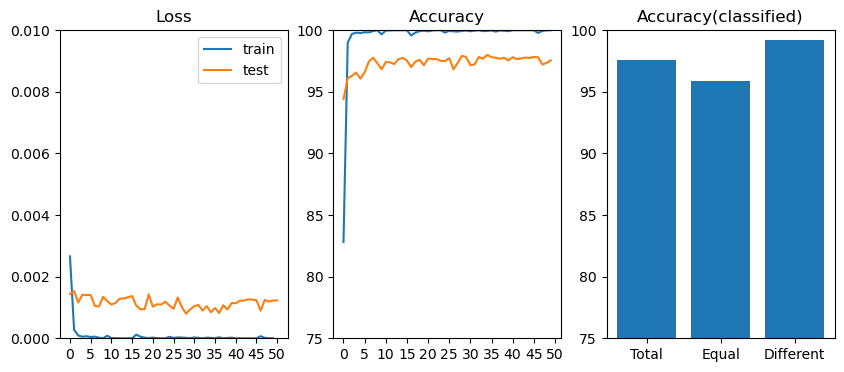

In [62]:
# draw losses and accuracies
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xticks(range(0, 51, 5))
plt.ylim(0, 0.01)
plt.legend()
plt.subplot(1, 3, 2)
plt.title('Accuracy')
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.xticks(range(0, 51, 5))
plt.ylim(75, 100)
plt.subplot(1, 3, 3)
plt.title('Accuracy(classified)')
plt.bar(['Total', 'Equal', 'Different'], [test_acc[-1], acc_equal, acc_different])
plt.ylim(75, 100)
plt.show()


### 结果分析

可以看到，ResNet18 的性能非常好，训练和测试 loss 一直保持在一个很小的水平；准确度也逐渐上升到97%附近。另外，相等数据的准确度不如不等数据。